In [1]:
import os
import sys
import tqdm
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
from functions import getLinearReg, createSBM, _createSBM

sys.path.append('./settings')
from mpl_settings_v3 import *

data_dir = '../data'
figs_dir = '../figures'

In [4]:
N = 1000
Nc = 10
k = 4
kin = 1
iterations = 100
meank_values = np.zeros(iterations)
for i in range(iterations):
    #G = createSBM(N, nc, k, pin, output='ig')
    #G = createSBM(N, Nc, k, kin, output='ig')
    
    kout = k - kin
    
    pin = kin / (Nc-1)
    pout = kout / (N-Nc)
    
    G = _createSBM(N, Nc, pin, pout)
    meank = np.mean(G.degree())
    meank_values[i] = meank

(array([ 3., 10., 11., 20., 22., 18.,  8.,  4.,  2.,  2.]),
 array([3.81  , 3.8528, 3.8956, 3.9384, 3.9812, 4.024 , 4.0668, 4.1096,
        4.1524, 4.1952, 4.238 ]),
 <a list of 10 Patch objects>)

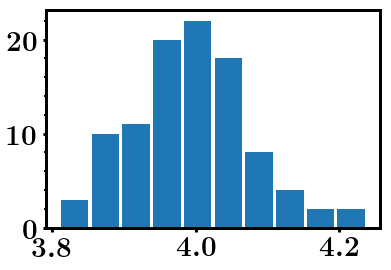

In [3]:
plt.hist(meank_values, rwidth=0.9)

In [234]:
def get_k_mat(G, Nc):
    l = N // Nc

    k_mat = np.zeros((l,l))
    for e in G.es():
        u, v = sorted(e.tuple)
        
        Cu, Cv = int(u/Nc), int(v/Nc)
        k_mat[Cu, Cv] = k_mat[Cu, Cv] + 1
        if Cu != Cv:
            k_mat[Cv, Cu] = k_mat[Cv, Cu] + 1   
    
    diag = np.eye(l, dtype='bool')
    
    print(np.sum(k_mat))
    
    k_mat[diag] = 2*k_mat[diag] / Nc
    k_mat[~diag] = k_mat[~diag] / Nc
    
    return k_mat

def get_kin(k_mat):
    l = k_mat.shape[0]
    trace = np.trace(k_mat)
    kin = trace / l
    return kin

k = 10
kin = 3
Nc = 10
N = 1000

G = createSBM(N, Nc, k, kin, output='ig')
print(G.summary())
k_mat = get_k_mat(G, Nc)

get_kin(k_mat)

1000 100 10 10 3 999 5026
IGRAPH U--- 1000 5026 -- 
8598.0


2.9079999999999995

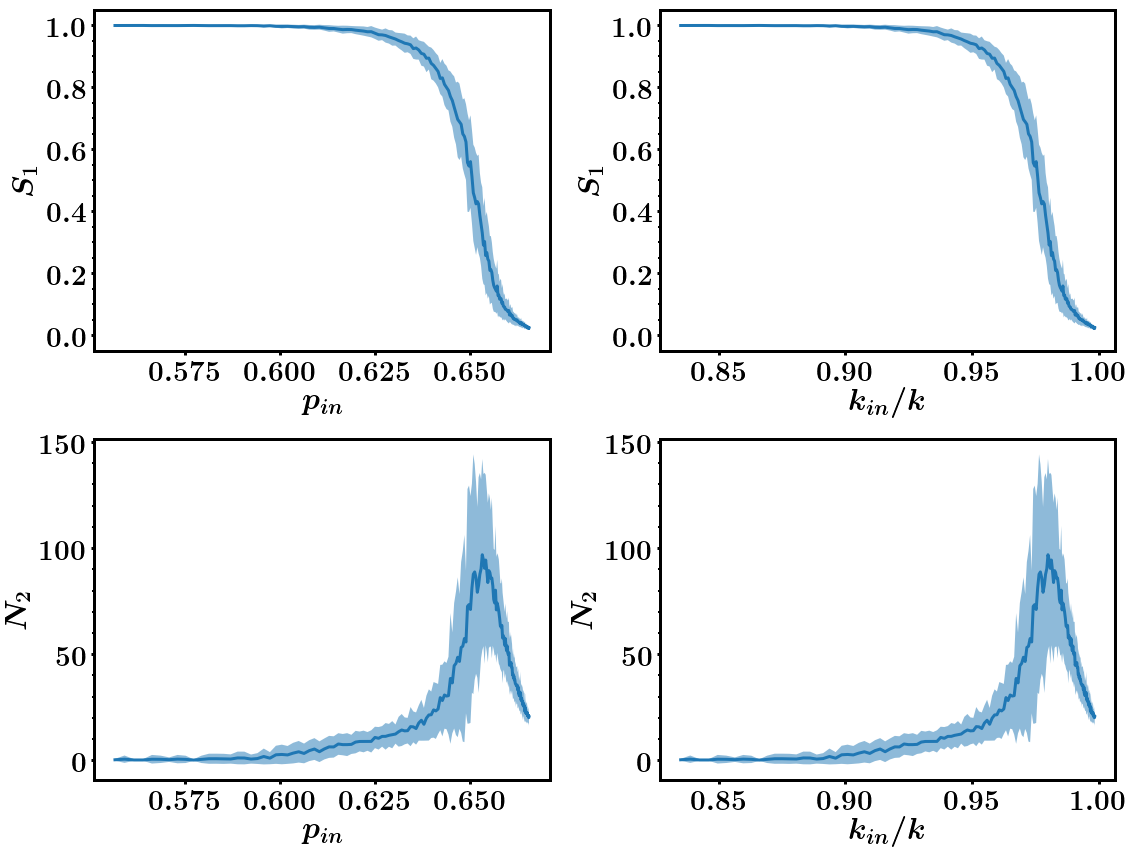

In [372]:
pout_values = mean_df.index
kout_values = pout_values * (N-Nc)
kin_values = k - kout_values
pin_values = kin_values / (Nc-1)

S1_values = mean_df.Ngcc / N
N2_values = mean_df.Nsec

std_S1_values = std_df.Ngcc / N
std_N2_values = std_df.Nsec

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes[0]:
    ax.set_ylim(-0.05, 1.05)

for ax in axes[:,0]:
    ax.set_xlabel(r'$p_{in}$')


for ax in axes[:,1]:
    ax.set_xlabel(r'$k_{in}/k$')

    
ax = axes[0][0]
ax.set_ylabel(r'$S_1$')
ax.plot(pin_values, S1_values)
ax.fill_between(pin_values, S1_values - std_S1_values, S1_values + std_S1_values, alpha=0.5)

ax = axes[1][0]
ax.set_ylabel(r'$N_2$')
ax.plot(pin_values, N2_values)
ax.fill_between(pin_values, N2_values - std_N2_values, N2_values + std_N2_values, alpha=0.5)


ax = axes[0][1]
ax.set_ylabel(r'$S_1$')
ax.plot(kin_values/k, S1_values)
ax.fill_between(kin_values/k, S1_values - std_S1_values, S1_values + std_S1_values, alpha=0.5)

ax = axes[1][1]
ax.set_ylabel(r'$N_2$')
ax.plot(kin_values/k, N2_values)
ax.fill_between(kin_values/k, N2_values - std_N2_values, N2_values + std_N2_values, alpha=0.5)


plt.tight_layout()
fig_name = csv_file_name[:-4] + '.png'
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

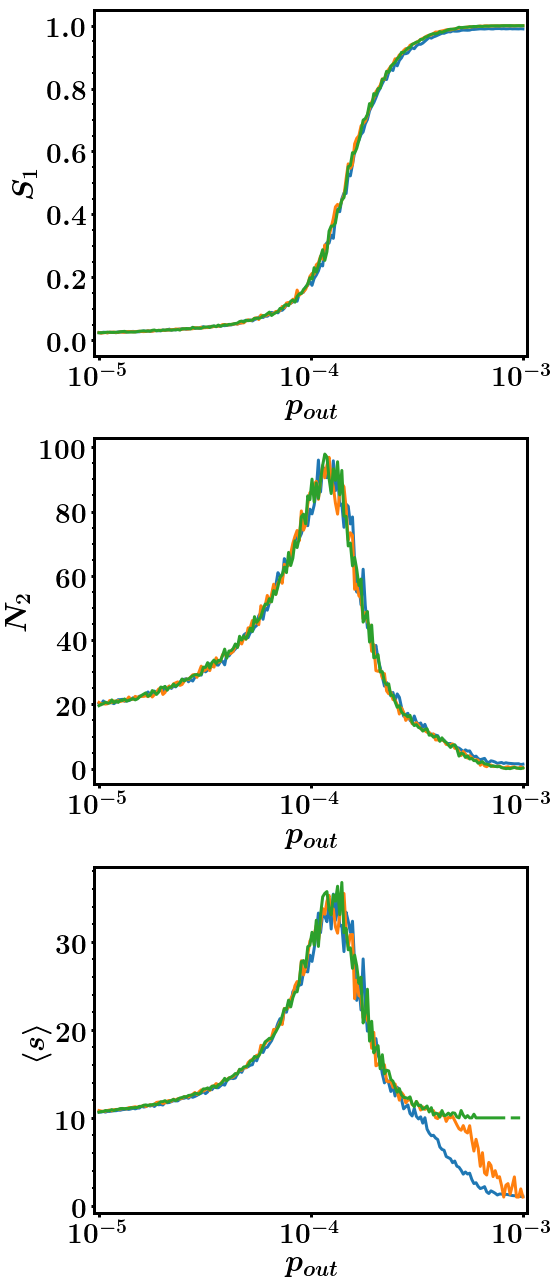

In [456]:
ncols = 1
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xlim(0.95*1e-5, 1.05*1e-3)
    ax.set_xscale('log')
    ax.set_xlabel(r'$p_{out}$')

for k in k_values:

    csv_file_name = 'N{}_Nc{}_k{:.2f}_poutmin{:.2f}_poutmax{}_it{}_samples{}_{}.csv'.format(
        N, Nc, k, poutmin, poutmax, iterations, samples, spacing
    )
    full_csv_file_name = os.path.join(data_dir, csv_file_name)
    df = pd.read_csv(full_csv_file_name)
    
    mean_df = df.groupby(by='pout').mean()
    std_df = df.groupby(by='pout').std()  
    
    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS

    ax = axes[0]
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(pout_values, S1_values, label=r'$k={{{}}}$'.format(k))

    ax = axes[1]
    ax.set_ylabel(r'$N_2$')
    ax.plot(pout_values, N2_values)
    
    ax = axes[2]
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.plot(pout_values, meanS_values)

plt.tight_layout()
fig_name = 'N{}_Nc{}_it{}_samples{}_{}.png'.format(
        N, Nc, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

In [480]:
Nc = 10
spacing = 'Log'
iterations = 100
samples = 200
poutmin = 1e-5
poutmax = 1e-3

k = 4
N_values = [250, 500, 1000, 2000, 4000]
data = []
for N in N_values:

    csv_file_name = 'N{}_Nc{}_k{:.2f}_poutmin{:.2f}_poutmax{}_it{}_samples{}_{}.csv'.format(
        N, Nc, k, poutmin, poutmax, iterations, samples, spacing
    )
    full_csv_file_name = os.path.join(data_dir, csv_file_name)
    df = pd.read_csv(full_csv_file_name)
    
    mean_df = df.groupby(by='pout').mean()
    std_df = df.groupby(by='pout').std()  
    
    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS
    
    N2_idxmax = N2_values.idxmax()
    meanS_idxmax = meanS_values.idxmax()
    
    row = [N, N2_values[N2_idxmax], std_N2_values[N2_idxmax],
        meanS_values[meanS_idxmax], std_meanS_values[meanS_idxmax]
    ]
    data.append(row)
max_df = pd.DataFrame(data, columns=['N', 'N2', 'N2std', 'meanS', 'meanSstd'])
max_df

,N,N2,N2std,meanS,meanSstd
0,250,37.26,18.542128,22.187854,12.964154
1,500,61.11,25.792840,28.176916,11.714772
2,1000,96.03,38.580483,35.425451,18.839581
3,2000,161.77,68.212362,47.568695,27.623881
4,4000,269.78,162.504302,63.930647,42.800902


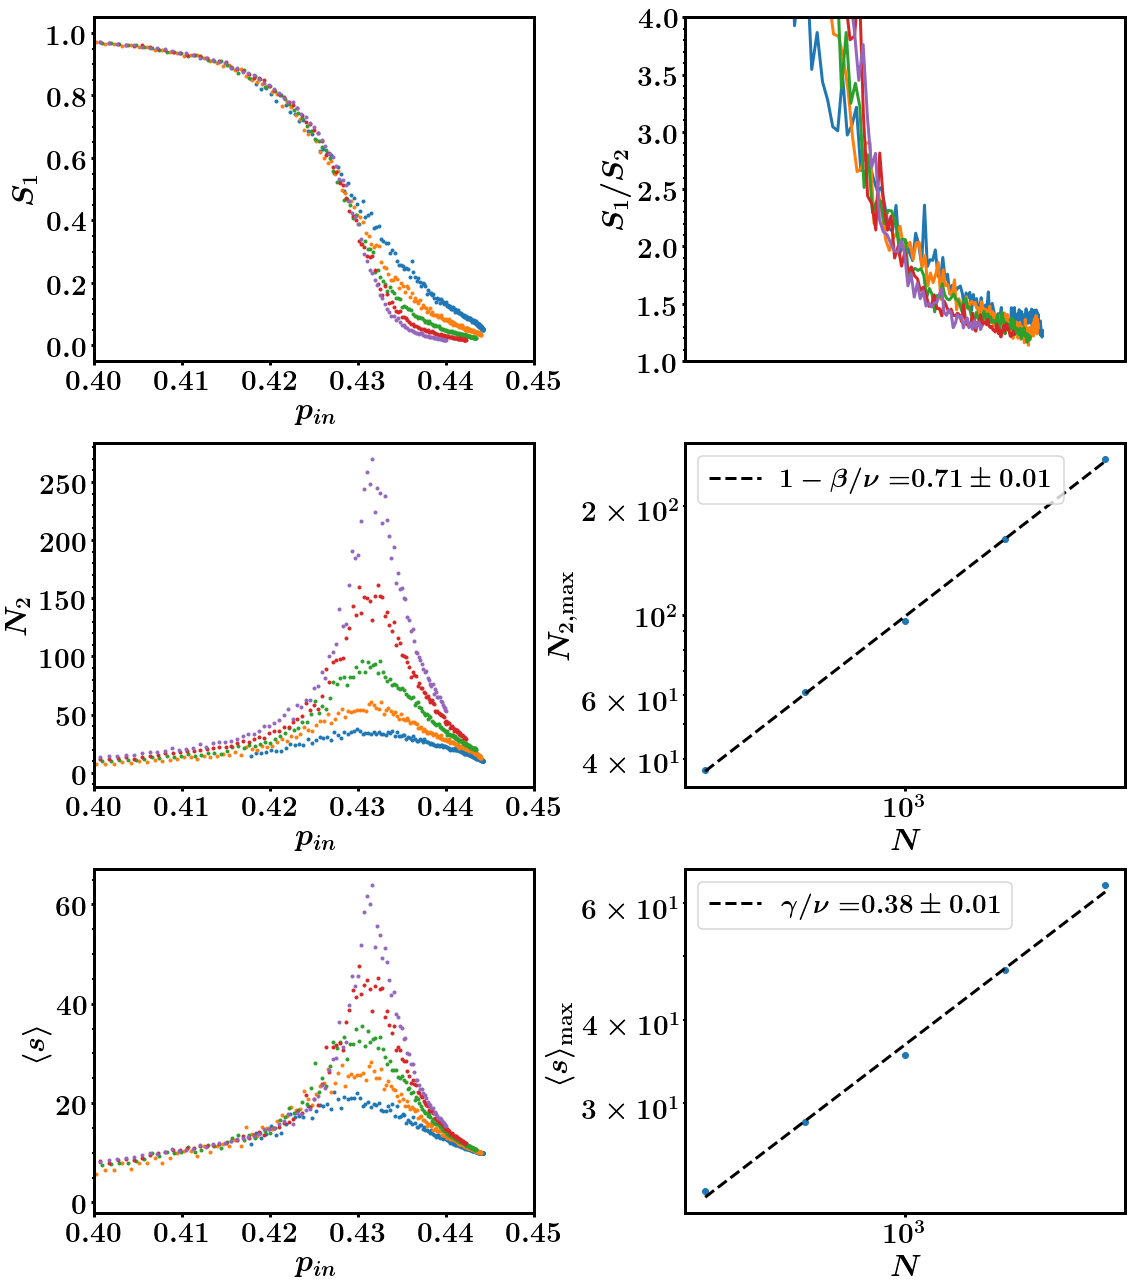

In [481]:
x_axis = 'pin'  

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes[:,0]:
    if x_axis == 'pout':
        ax.set_xlim(0.95*1e-5, 1.05*1e-3)
        ax.set_xscale('log')
        ax.set_xlabel(r'$p_{out}$')
    elif x_axis == 'pin':
        ax.set_xlim(0.4, 0.45)
        ax.set_xlabel(r'$p_{in}$')
    

for N in N_values:

    csv_file_name = 'N{}_Nc{}_k{:.2f}_poutmin{:.2f}_poutmax{}_it{}_samples{}_{}.csv'.format(
        N, Nc, k, poutmin, poutmax, iterations, samples, spacing
    )
    full_csv_file_name = os.path.join(data_dir, csv_file_name)
    df = pd.read_csv(full_csv_file_name)
    
    mean_df = df.groupby(by='pout').mean()
    std_df = df.groupby(by='pout').std()
    
    pout_values = mean_df.index
    kout_values = pout_values * (N-Nc)
    kin_values = k - kout_values
    pin_values = kin_values / (Nc-1)

    if x_axis == 'pin':
        X = pin_values
    elif x_axis == 'pout':
        X = pout_values
    elif x_axis == 'kin':
        X = kin_values
    elif x_axis == 'kout':
        X = kout_values
    
    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS

    ax = axes[0,0]
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(X, S1_values, '.', label=r'$k={{{}}}$'.format(k))

    ax = axes[1,0]
    ax.set_ylabel(r'$N_2$')
    ax.plot(X, N2_values, '.')
    
    ax = axes[2,0]
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.plot(X, meanS_values, '.')
    
    ax = axes[0,1]
    ax.set_ylim(1., 4.)
    if x_axis == 'pout':
        ax.set_xlim(1e-5, 1e-4)
    elif x_axis == 'pin':
        ax.set_xlim(0.42, 0.45)
        ax.set_xscale('log')
    ax.set_ylabel(r'$S_1/S_2$')
    ax.plot(X, N*S1_values/N2_values)
    
ax = axes[1,1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$N_{2,\mathrm{max}}$')
ax.plot(max_df.N, max_df.N2, 'o', label='')
Y_pred, slope, slope_err, r2 = getLinearReg(max_df.N, max_df.N2)
ax.plot(max_df.N, Y_pred, '--', color='k', 
        label=r'$1-\beta/\nu =$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, slope_err))
ax.legend()

ax = axes[2,1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\langle s \rangle_{\mathrm{max}}$')
ax.plot(max_df.N, max_df.meanS, 'o', label='')
Y_pred, slope, slope_err, r2 = getLinearReg(max_df.N, max_df.meanS)
ax.plot(max_df.N, Y_pred, '--', color='k', 
        label=r'$\gamma/\nu =$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, slope_err))
ax.legend()

    
plt.tight_layout()
fig_name = 'k{:.2f}_Nc{}_it{}_samples{}_{}_xAxis{}.png'.format(
        k, Nc, it_per_kin, samples, spacing, x_axis
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

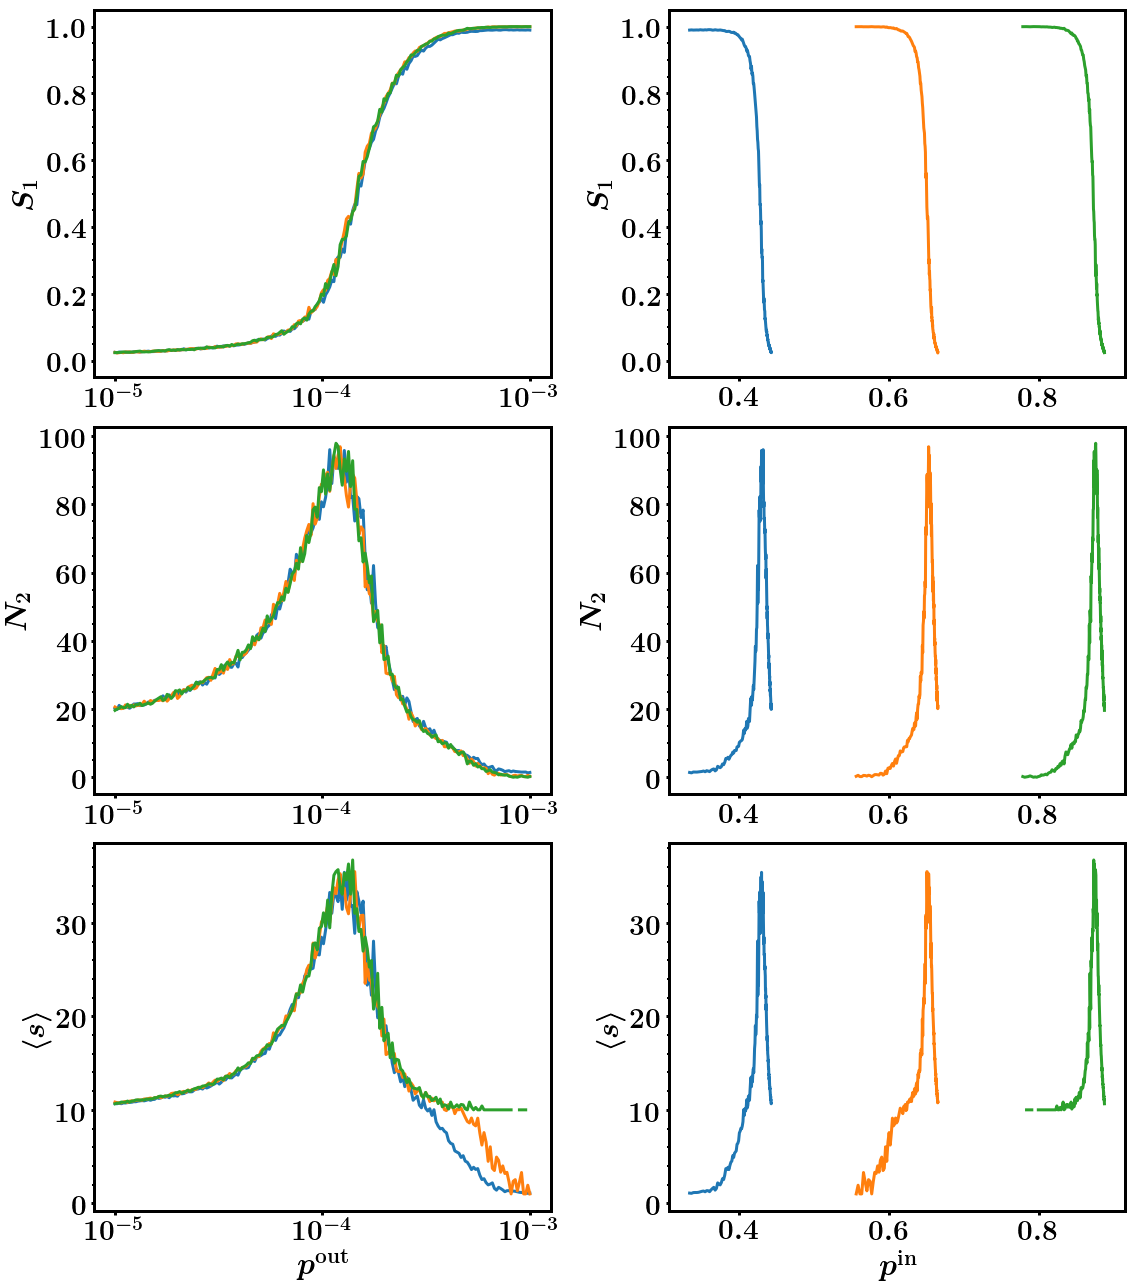

In [463]:
ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

#for ax in axes:
    #ax.set_xlim(0.95*1e-5, 1.05*1e-3)
    #ax.set_xscale('log')
    #ax.set_xlabel(r'$p_{out}$')

for k in k_values:

    csv_file_name = 'N{}_Nc{}_k{:.2f}_poutmin{:.2f}_poutmax{}_it{}_samples{}_{}.csv'.format(
        N, Nc, k, poutmin, poutmax, iterations, samples, spacing
    )
    full_csv_file_name = os.path.join(data_dir, csv_file_name)
    df = pd.read_csv(full_csv_file_name)
    
    mean_df = df.groupby(by='pout').mean()
    std_df = df.groupby(by='pout').std()  
    
    pout_values = mean_df.index
    kout_values = pout_values * (N-Nc)
    kin_values = k - kout_values
    pin_values = kin_values / (Nc-1)
    
    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS

    ax = axes[0,0]
    ax.set_xscale('log')
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(pout_values, S1_values, label=r'$k={{{}}}$'.format(k))
    #ax.plot(pin_values, S1_values, label=r'$k={{{}}}$'.format(k))

    ax = axes[1,0]
    ax.set_xscale('log')
    ax.set_ylabel(r'$N_2$')
    ax.plot(pout_values, N2_values)
    
    ax = axes[2,0]
    ax.set_xscale('log')
    ax.set_xlabel(r'$p^{\mathrm{out}}$')
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.plot(pout_values, meanS_values)
    
    ax = axes[0,1]
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(pin_values, S1_values, label=r'$k={{{}}}$'.format(k))

    ax = axes[1,1]
    ax.set_ylabel(r'$N_2$')
    ax.plot(pin_values, N2_values)
    
    ax = axes[2,1]
    ax.set_xlabel(r'$p^{\mathrm{in}}$')
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.plot(pin_values, meanS_values)

plt.tight_layout()
fig_name = 'N{}_Nc{}_it{}_samples{}_{}.png'.format(
        N, Nc, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

### Plot for different $N$

250 100
500 100
1000 100
2000 100
4000 10


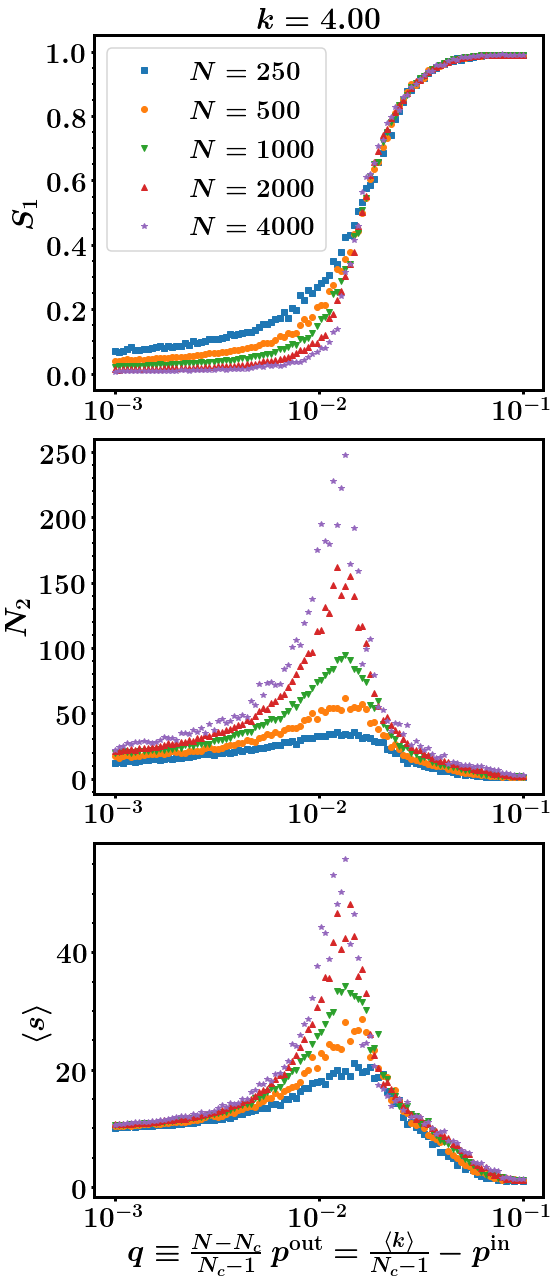

In [593]:
it_values = [1000, 100, 10]
samples = 100

qin_minmax = {
    10: [1e-3, 1e-1],
    20: [1e-4, 5*1e-2],
    40: [1e-6, 1e-3]
}

ncols = 1
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')

k = 4
N_values = [250, 500, 1000, 2000, 4000]
Nc = 10
for j, N in enumerate(N_values):

    pin_max = k / (Nc-1)

    qinmin, qinmax = qin_minmax[Nc]

    file_ok = False
    for iterations in it_values: 
        csv_file_name = 'N{}_Nc{}_k{:.2f}_qinmin{:.6f}_qinmax{:.6f}_it{}_samples{}_{}.csv'.format(
            N, Nc, k, qinmin, qinmax, iterations, samples, spacing
        )
        full_csv_file_name = os.path.join(data_dir, csv_file_name)
        if os.path.isfile(full_csv_file_name):
            df = pd.read_csv(full_csv_file_name)
            file_ok = True
            print(N, iterations)
            break

    if not file_ok:
        print(csv_file_name)
        continue

    mean_df = df.groupby(by='pin').mean()
    std_df = df.groupby(by='pin').std()  

    pin_values = mean_df.index
    qin_values = k / (Nc-1) - pin_values

    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS

    ax = axes[0]
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(qin_values, S1_values, markers[j], color=colors[j], 
            label=r'$N={{{}}}$'.format(N))


    ax = axes[1]
    ax.set_ylabel(r'$N_2$')
    ax.plot(qin_values, N2_values, markers[j], color=colors[j])

    ax = axes[2]
    ax.set_xlabel(r'$q \equiv \frac{N - N_c}{N_c - 1} \;p^{\mathrm{out}} = \frac{\langle k \rangle}{N_c - 1} - p^{\mathrm{in}}$')
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.plot(qin_values, meanS_values, markers[j], color=colors[j])
        
axes[0].legend(loc='best')
axes[0].set_title(r'$k = {{{:.2f}}}$'.format(k), fontsize=30)
plt.tight_layout()
fig_name = 'k{:.2f}_Nc{}_it{}_samples{}_{}.png'.format(
        k, Nc, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

In [665]:
Nc = 10
spacing = 'Log'
it_values = [1000, 100, 10]
samples = 100

qin_minmax = {
    10: [1e-3, 1e-1],
    20: [1e-4, 5*1e-2],
    40: [1e-6, 1e-3]
}

k = 4
N_values = [250, 500, 1000, 2000]
data = []
for N in N_values:
    
    qinmin, qinmax = qin_minmax[Nc]

    file_ok = False
    for iterations in it_values: 
        csv_file_name = 'N{}_Nc{}_k{:.2f}_qinmin{:.6f}_qinmax{:.6f}_it{}_samples{}_{}.csv'.format(
            N, Nc, k, qinmin, qinmax, iterations, samples, spacing
        )
        full_csv_file_name = os.path.join(data_dir, csv_file_name)
        if os.path.isfile(full_csv_file_name):
            df = pd.read_csv(full_csv_file_name)
            file_ok = True
            print(N, iterations)
            break

    if not file_ok:
        print(csv_file_name)
        continue
    
    mean_df = df.groupby(by='pin').mean()
    std_df = df.groupby(by='pin').std()  

    pin_values = mean_df.index
    qin_values = k / (Nc-1) - pin_values 
    
    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS
    
    N2_idxmax = N2_values.idxmax()
    meanS_idxmax = meanS_values.idxmax()
    
    row = [N, N2_values[N2_idxmax], std_N2_values[N2_idxmax],
        meanS_values[meanS_idxmax], std_meanS_values[meanS_idxmax]
    ]
    data.append(row)
max_df = pd.DataFrame(data, columns=['N', 'N2', 'N2std', 'meanS', 'meanSstd'])
max_df

250 100
500 100
1000 100
2000 100


,N,N2,N2std,meanS,meanSstd
0,250,35.60,16.111355,21.196653,8.827840
1,500,61.76,26.587048,28.646158,18.492198
2,1000,94.81,49.133645,34.208580,16.504540
3,2000,162.04,75.726904,48.192617,33.363892


250 100
500 100
1000 100
2000 100


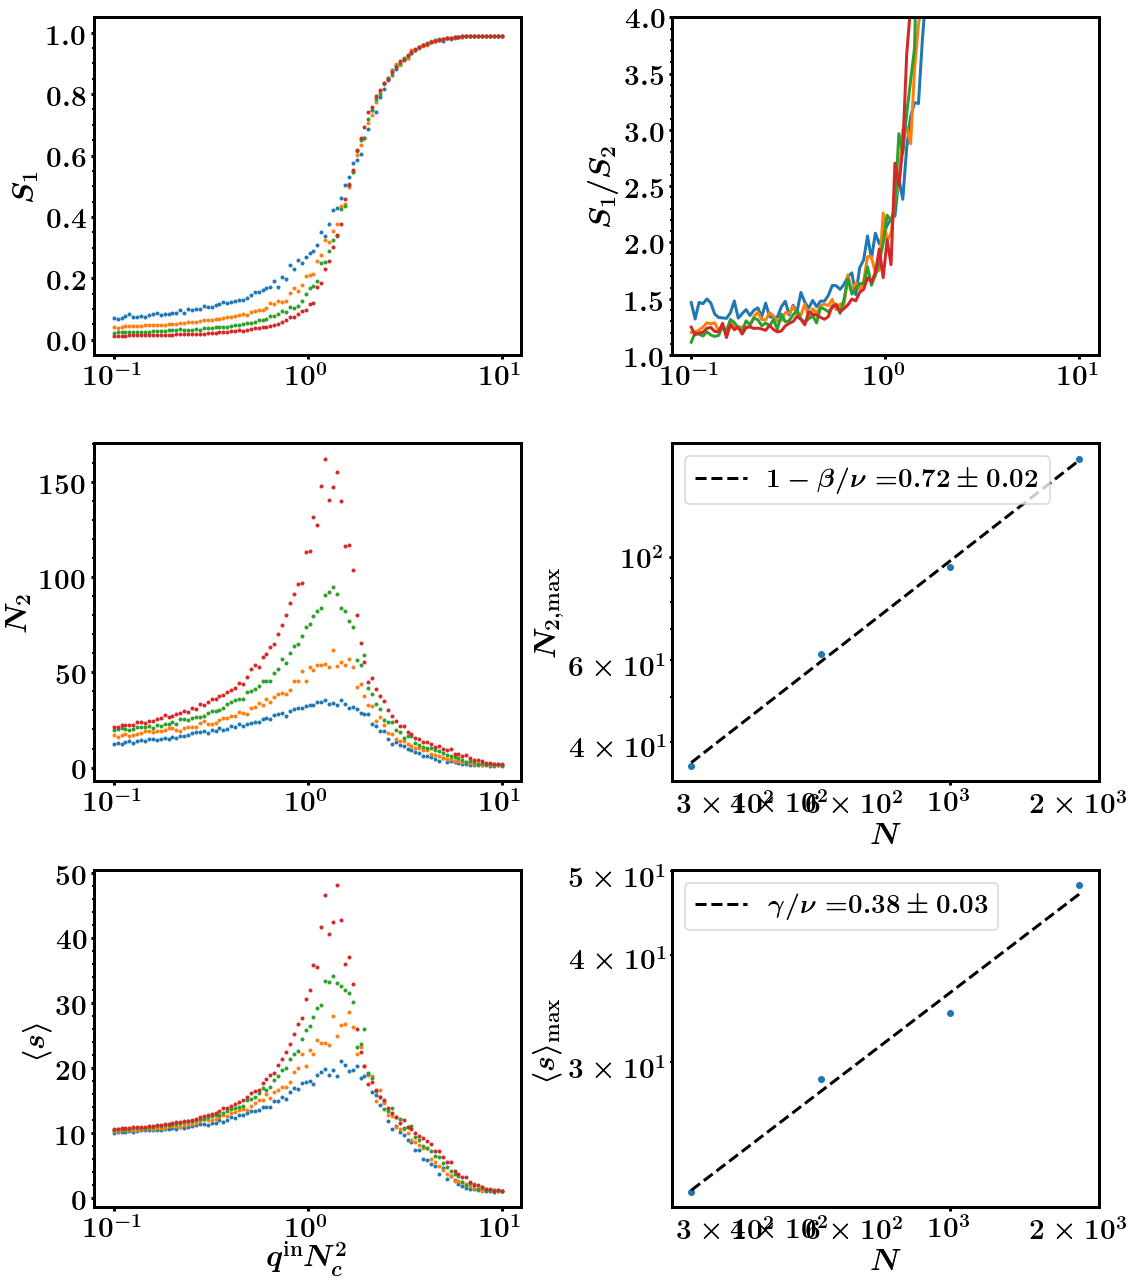

In [666]:
ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)  

for ax in axes[:,0]:
    ax.set_xscale('log')

for N in N_values:

    file_ok = False
    for iterations in it_values: 
        csv_file_name = 'N{}_Nc{}_k{:.2f}_qinmin{:.6f}_qinmax{:.6f}_it{}_samples{}_{}.csv'.format(
            N, Nc, k, qinmin, qinmax, iterations, samples, spacing
        )
        full_csv_file_name = os.path.join(data_dir, csv_file_name)
        if os.path.isfile(full_csv_file_name):
            df = pd.read_csv(full_csv_file_name)
            file_ok = True
            print(N, iterations)
            break

    if not file_ok:
        print(csv_file_name)
        continue
    
    mean_df = df.groupby(by='pin').mean()
    std_df = df.groupby(by='pin').std()  

    pin_values = mean_df.index
    qin_values = k / (Nc-1) - pin_values

    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS

    X = qin_values * Nc**2

    ax = axes[0,0]
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(X, S1_values, '.', label=r'$k={{{}}}$'.format(k))

    ax = axes[1,0]
    ax.set_ylabel(r'$N_2$')
    ax.plot(X, N2_values, '.')
    
    ax = axes[2,0]
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.set_xlabel(r'$q^{\mathrm{in}} N_c^2$')
    ax.plot(X, meanS_values, '.')
    
    ax = axes[0,1]
    ax.set_ylim(1., 4.)
    ax.set_xscale('log')
    ax.set_ylabel(r'$S_1/S_2$')
    ax.plot(X, N*S1_values/N2_values)
    
ax = axes[1,1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$N_{2,\mathrm{max}}$')
ax.plot(max_df.N, max_df.N2, 'o', label='')
Y_pred, slope, slope_err, r2 = getLinearReg(max_df.N, max_df.N2)
ax.plot(max_df.N, Y_pred, '--', color='k', 
        label=r'$1-\beta/\nu =$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, slope_err))
ax.legend()

ax = axes[2,1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\langle s \rangle_{\mathrm{max}}$')
ax.plot(max_df.N, max_df.meanS, 'o', label='')
Y_pred, slope, slope_err, r2 = getLinearReg(max_df.N, max_df.meanS)
ax.plot(max_df.N, Y_pred, '--', color='k', 
        label=r'$\gamma/\nu =$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, slope_err))
ax.legend()

    
plt.tight_layout()
fig_name = 'scaling_k{:.2f}_Nc{}_it{}_samples{}_{}.png'.format(
        k, Nc, it_per_kin, samples, spacing
)
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

### Plot for different $k$

1 1000
2 100
3 100
4 100
5 100
8 100


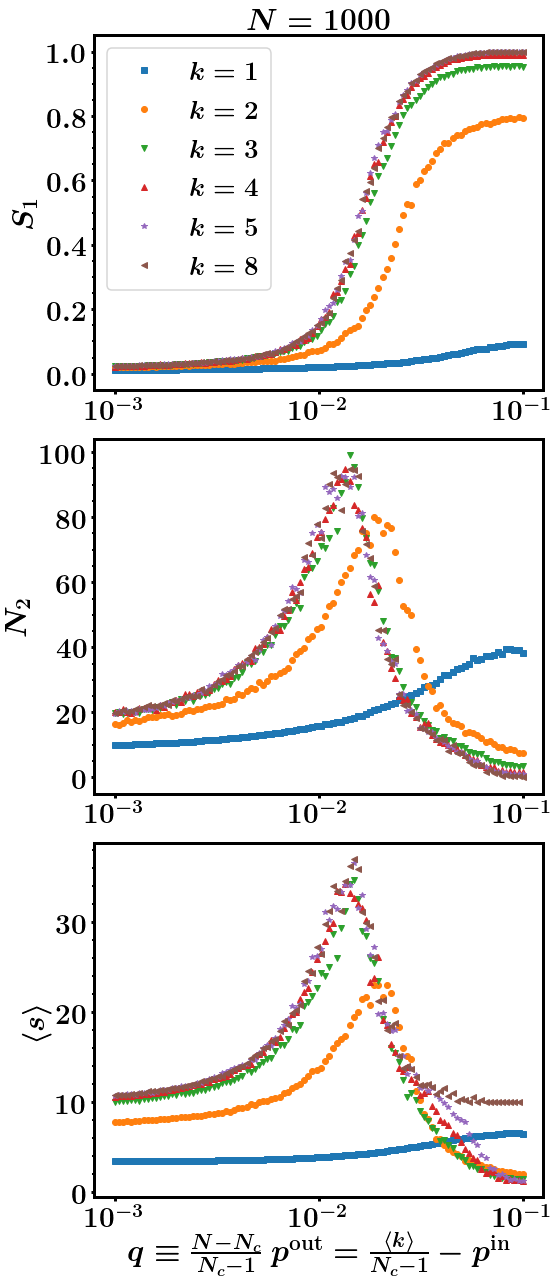

In [594]:
it_values = [1000, 100, 10]
samples = 100

qin_minmax = {
    10: [1e-3, 1e-1],
    20: [1e-4, 5*1e-2],
    40: [1e-6, 1e-3]
}

ncols = 1
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')

N = 1000
k_values = [1, 2, 3, 4, 5, 8]
Nc = 10

for j, k in enumerate(k_values):

    pin_max = k / (Nc-1)

    qinmin, qinmax = qin_minmax[Nc]

    file_ok = False
    for iterations in it_values: 
        csv_file_name = 'N{}_Nc{}_k{:.2f}_qinmin{:.6f}_qinmax{:.6f}_it{}_samples{}_{}.csv'.format(
            N, Nc, k, qinmin, qinmax, iterations, samples, spacing
        )
        full_csv_file_name = os.path.join(data_dir, csv_file_name)
        if os.path.isfile(full_csv_file_name):
            df = pd.read_csv(full_csv_file_name)
            file_ok = True
            print(k, iterations)
            break

    if not file_ok:
        print(csv_file_name)
        continue

    mean_df = df.groupby(by='pin').mean()
    std_df = df.groupby(by='pin').std()  

    pin_values = mean_df.index
    qin_values = k / (Nc-1) - pin_values

    S1_values = mean_df.Ngcc / N
    N2_values = mean_df.Nsec
    meanS_values = mean_df.meanS

    std_S1_values = std_df.Ngcc / N
    std_N2_values = std_df.Nsec
    std_meanS_values = std_df.meanS

    ax = axes[0]
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(r'$S_1$')
    ax.plot(qin_values, S1_values, markers[j], color=colors[j], 
            label=r'$k={{{:.0f}}}$'.format(k))


    ax = axes[1]
    ax.set_ylabel(r'$N_2$')
    ax.plot(qin_values, N2_values, markers[j], color=colors[j])

    ax = axes[2]
    ax.set_xlabel(r'$q \equiv \frac{N - N_c}{N_c - 1} \;p^{\mathrm{out}} = \frac{\langle k \rangle}{N_c - 1} - p^{\mathrm{in}}$')
    ax.set_ylabel(r'$\langle s \rangle$')
    ax.plot(qin_values, meanS_values, markers[j], color=colors[j])
axes[0].legend(loc='best')
axes[0].set_title(r'$N={{{}}}$'.format(N), fontsize=30)

plt.tight_layout()
fig_name = 'N{}_Nc{}_it{}_samples{}_{}.png'.format(
        N, Nc, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

### Plot different $N_c$

10 100
10 100
10 10
20 100
20 100
20 100
40 100
40 100
40 10
80 10
80 10
80 10


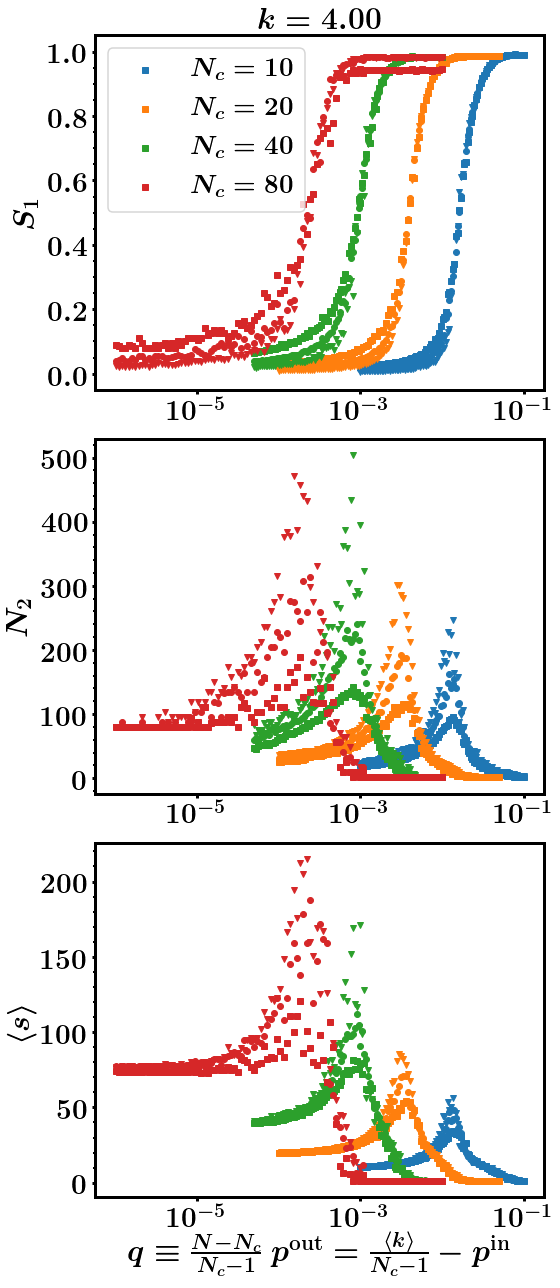

In [598]:
it_values = [1000, 100, 10]
samples = 100

qin_minmax = {
    10: [1e-3, 1e-1],
    20: [1e-4, 5*1e-2],
    40: [5*1e-5, 1e-2],
    80: [1e-6, 1e-2]
}

ncols = 1
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')

Nc_values = [10, 20, 40, 80]
k = 4
N_values = [1000, 2000, 4000]

for j, Nc in enumerate(Nc_values):
    for i, N in enumerate(N_values):    
        pin_max = k / (Nc-1)

        qinmin, qinmax = qin_minmax[Nc]

        file_ok = False
        for iterations in it_values: 
            csv_file_name = 'N{}_Nc{}_k{:.2f}_qinmin{:.6f}_qinmax{:.6f}_it{}_samples{}_{}.csv'.format(
                N, Nc, k, qinmin, qinmax, iterations, samples, spacing
            )
            full_csv_file_name = os.path.join(data_dir, csv_file_name)
            if os.path.isfile(full_csv_file_name):
                df = pd.read_csv(full_csv_file_name)
                file_ok = True
                print(Nc, iterations)
                break
            
        if not file_ok:
            print(csv_file_name)
            continue

        mean_df = df.groupby(by='pin').mean()
        std_df = df.groupby(by='pin').std()  

        pin_values = mean_df.index
        qin_values = k / (Nc-1) - pin_values

        S1_values = mean_df.Ngcc / N
        N2_values = mean_df.Nsec
        meanS_values = mean_df.meanS

        std_S1_values = std_df.Ngcc / N
        std_N2_values = std_df.Nsec
        std_meanS_values = std_df.meanS

        ax = axes[0]
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(r'$S_1$')
        
        if N == N_values[0]:
            label = r'$N_c={{{:.0f}}}$'.format(Nc)
        else:
            label = ''
        
        ax.plot(qin_values, S1_values, markers[i], color=colors[j], 
                label=label)


        ax = axes[1]
        ax.set_ylabel(r'$N_2$')
        ax.plot(qin_values, N2_values, markers[i], color=colors[j])

        ax = axes[2]
        ax.set_xlabel(r'$q \equiv \frac{N - N_c}{N_c - 1} \;p^{\mathrm{out}} = \frac{\langle k \rangle}{N_c - 1} - p^{\mathrm{in}}$')
        ax.set_ylabel(r'$\langle s \rangle$')
        ax.plot(qin_values, meanS_values, markers[i], color=colors[j])
axes[0].legend(loc='best')
axes[0].set_title(r'$k = {{{:.2f}}}$'.format(k), fontsize=30)

plt.tight_layout()
fig_name = 'N{}_k{:.2f}_it{}_samples{}_{}.png'.format(
        N, k, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

10 100
10 100
10 100
20 100
20 100
20 100
40 100
40 100
40 100
80 100
80 100
80 100


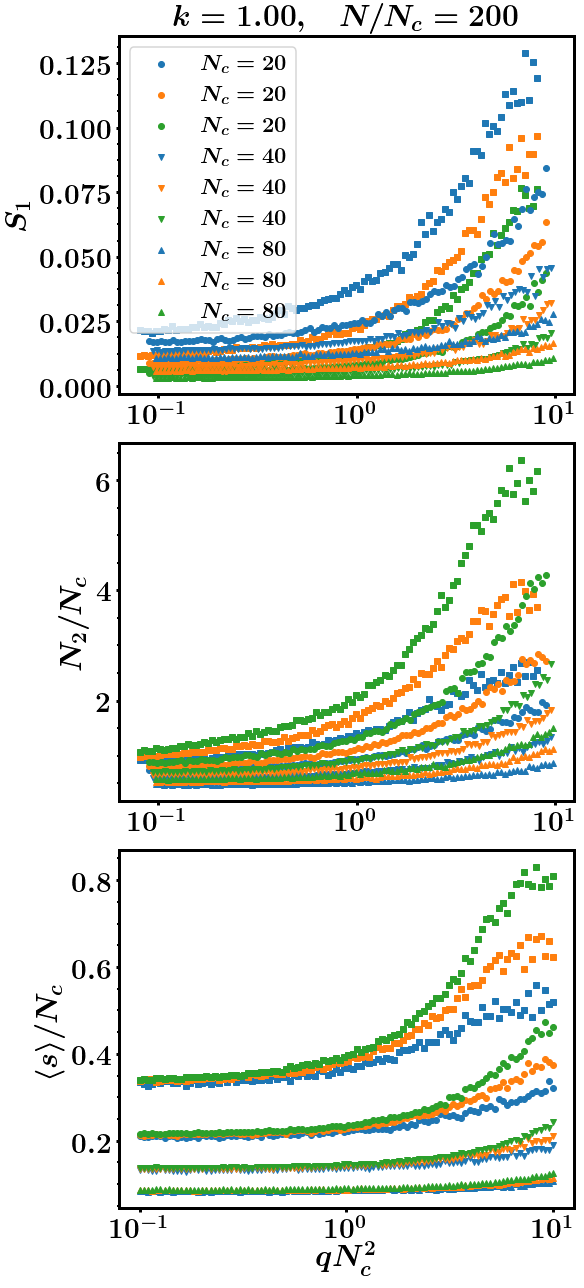

In [647]:
it_values = [1000, 100, 10]
samples = 100

ncols = 1
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')

Nc_values = [10, 20, 40, 80]
k = 1
N_over_Nc_values = [50, 100, 200]
xmin = 0.1
xmax = 10

for i, Nc in enumerate(Nc_values):
    for j, N_over_Nc in enumerate(N_over_Nc_values):
        
        N = N_over_Nc * Nc
        pin_max = k / (Nc-1)

        qinmin = xmin / Nc**2
        qinmax = xmax / Nc**2

        file_ok = False
        for iterations in it_values: 
            csv_file_name = 'N{}_Nc{}_k{:.2f}_xmin{:.4f}_xmax{:.4f}_it{}_samples{}_{}.csv'.format(
                N, Nc, k, xmin, xmax, iterations, samples, spacing
            )
            full_csv_file_name = os.path.join(data_dir, csv_file_name)
            if os.path.isfile(full_csv_file_name):
                df = pd.read_csv(full_csv_file_name)
                file_ok = True
                print(Nc, iterations)
                break
            
        if not file_ok:
            print(csv_file_name)
            continue

        mean_df = df.groupby(by='pin').mean()
        std_df = df.groupby(by='pin').std()  

        pin_values = mean_df.index
        qin_values = k / (Nc-1) - pin_values

        S1_values = mean_df.Ngcc / N
        N2_values = mean_df.Nsec
        meanS_values = mean_df.meanS

        std_S1_values = std_df.Ngcc / N
        std_N2_values = std_df.Nsec
        std_meanS_values = std_df.meanS

        ax = axes[0]
        #ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(r'$S_1$')
        
        if i == 0:
            label = ''
        else:
            label = r'$N_c={{{:.0f}}}$'.format(Nc)
        ax.plot(qin_values*(Nc-1)**2, S1_values, markers[i], color=colors[j], 
                label=label)

        ax = axes[1]
        ax.set_ylabel(r'$N_2 / N_c$')
        ax.plot(qin_values*(Nc-1)**2, N2_values/Nc, markers[i], color=colors[j])

        ax = axes[2]
        ax.set_xlabel(r'$q N_c^2$')
        ax.set_ylabel(r'$\langle s \rangle / N_c$')
        ax.plot(qin_values*Nc**2, meanS_values/Nc, markers[i], color=colors[j])
axes[0].legend(loc='best', fontsize=22)
axes[0].set_title(r'$k = {{{:.2f}}},\quad N/N_c = {{{}}}$'.format(k, N//Nc), fontsize=30)

plt.tight_layout()
fig_name = 'NoverNc{}_k{:.2f}_it{}_samples{}_{}.png'.format(
        N//Nc, k, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

10 10
20 10
40 10
80 10


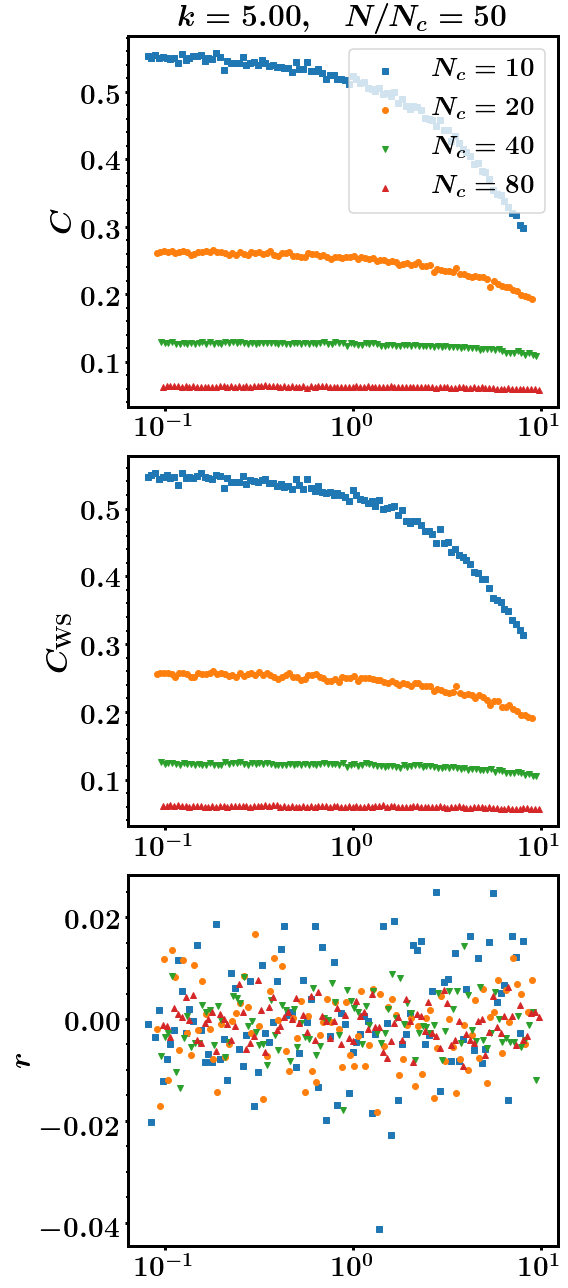

In [635]:
it_values = [1000, 100, 10]
samples = 100

ncols = 1
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')

Nc_values = [10, 20, 40, 80]
k = 5
N_over_Nc = 50
xmin = 0.1
xmax = 10

for i, Nc in enumerate(Nc_values):
        j = i
        N = N_over_Nc * Nc
        pin_max = k / (Nc-1)

        qinmin = xmin / Nc**2
        qinmax = xmax / Nc**2

        file_ok = False
        for iterations in it_values: 
            csv_file_name = 'N{}_Nc{}_k{:.2f}_xmin{:.4f}_xmax{:.4f}_it{}_samples{}_{}.csv'.format(
                N, Nc, k, xmin, xmax, iterations, samples, spacing
            )
            full_csv_file_name = os.path.join(data_dir, csv_file_name)
            if os.path.isfile(full_csv_file_name):
                df = pd.read_csv(full_csv_file_name)
                file_ok = True
                print(Nc, iterations)
                break
            
        if not file_ok:
            print(csv_file_name)
            continue

        mean_df = df.groupby(by='pin').mean()
        std_df = df.groupby(by='pin').std()  

        pin_values = mean_df.index
        qin_values = k / (Nc-1) - pin_values

        C_values = mean_df.C
        Cws_values = mean_df.Cws
        r_values = mean_df.r
        
        std_C_values = std_df.C
        std_Cws_values = std_df.Cws
        std_r_values = std_df.r

        
        ax = axes[0]
        ax.set_ylabel(r'$C$')
        
        label = r'$N_c={{{:.0f}}}$'.format(Nc)
        ax.plot(qin_values*(Nc-1)**2, C_values, markers[i], color=colors[j], 
                label=label)

        ax = axes[1]
        ax.set_ylabel(r'$C_{\mathrm{WS}}$')
        ax.plot(qin_values*(Nc-1)**2, Cws_values, markers[i], color=colors[j])
        
        ax = axes[2]
        ax.set_ylabel(r'$r$')
        ax.plot(qin_values*(Nc-1)**2, r_values, markers[i], color=colors[j])

axes[0].legend(loc='best')
axes[0].set_title(r'$k = {{{:.2f}}},\quad N/N_c = {{{}}}$'.format(k, N//Nc), fontsize=30)

plt.tight_layout()
fig_name = 'clustering_NoverNc{}_k{:.2f}_it{}_samples{}_{}.png'.format(
        N//Nc, k, it_per_kin, samples, spacing
    )
plt.savefig(os.path.join(figs_dir, fig_name))
plt.show()

In [4]:
import time

In [20]:
nc = 10
pin = 0.1
pout = 0.2
it = 1
N_values = [250, 500, 1000, 2000, 4000, 8000, 16000]
data = []
for N in N_values:
    init_time = time.time()
    for i in range(it):
        G = createSBM(N, nc, pin, pout)
    final_time = time.time()
    createSBM_t = final_time - init_time
    
    init_time = time.time()
    for i in range(it):
        G.transitivity_undirected(mode='zeros')
    final_time = time.time()
    C_t = final_time - init_time
    
    init_time = time.time()
    for i in range(it):
        G.transitivity_avglocal_undirected(mode='zeros')
    final_time = time.time()
    Cws_t = final_time - init_time
    
    init_time = time.time()
    for i in range(it):
        G.assortativity_degree(directed=False)
    final_time = time.time()
    r_t = final_time - init_time
    
    row = [N, createSBM_t, C_t, Cws_t, r_t]
    data.append(row)
    
df = pd.DataFrame(data, columns=['N', 'create', 'C', 'Cws', 'r'])
df

,N,create,C,Cws,r
0,250,0.014590,0.001163,0.001727,0.000039
1,500,0.022261,0.019692,0.031978,0.000113
2,1000,0.082650,0.085146,0.153837,0.000404
3,2000,0.239456,0.625307,0.998408,0.001491
4,4000,1.163191,5.379094,9.639466,0.005841
5,8000,5.050743,47.326667,86.796005,0.024437
6,16000,25.168897,395.801512,637.637181,0.134966


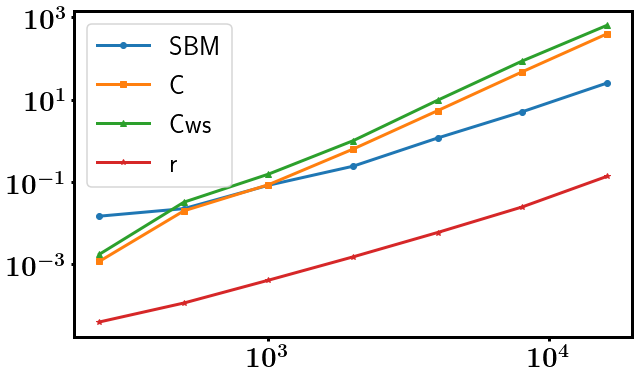

In [21]:
#X = np.logspace(np.log10(df.N[0]), np.log10(df.N[-1]))

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(df.N, df.create, '-o', label='SBM')
ax.plot(df.N, df.C, '-s', label='C')
ax.plot(df.N, df.Cws, '-^', label='Cws')
ax.plot(df.N, df.r, '-*', label='r')
ax.legend()
plt.show()